In [1]:
pip install tensorflow pydot graphviz

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Define the generator model with Gumbel
def build_generator_with_gumbel(noise_dim=100, num_landcover_classes=5):
    noise_input = layers.Input(shape=(noise_dim,), name='noise_input')  # Noise input
    soc_input = layers.Input(shape=(1,), name='soc_input')  # SOC input
    landcover_input = layers.Input(shape=(num_landcover_classes,), name='landcover_input')  # One-hot encoded landcover input

    # Concatenate inputs
    x = layers.Concatenate()([noise_input, soc_input, landcover_input])
   
    # Fully connected layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
   
    # Generate SOC output
    soc_output = layers.Dense(1, activation='linear', name='soc_output')(x)
   
    # Generate logits for landcover classification
    landcover_logits = layers.Dense(num_landcover_classes, name='landcover_logits')(x)

    # Create the model
    model = tf.keras.Model(inputs=[noise_input, soc_input, landcover_input], outputs=[soc_output, landcover_logits])
   
    return model

# Create the generator model
generator = build_generator_with_gumbel()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_input (InputLayer)  │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 106)               │               0 │ noise_input[0][0],         │
│                               │                           │                 │ soc_input[0][0],           │
│                               │                           │                 │ landcover_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          27,392 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         131,584 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_output (Dense)            │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_logits (Dense)      │ (None, 5)                 │           2,565 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 162,054 (633.02 KB)

 Trainable params: 162,054 (633.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define the Discriminator model
def build_discriminator_with_gumbel(num_landcover_classes=5):
    reflectance_input = layers.Input(shape=(234,), name='reflectance_input')  # Reflectance data input
    soc_input = layers.Input(shape=(1,), name='soc_input')  # SOC input (condition)
    landcover_input = layers.Input(shape=(num_landcover_classes,), name='landcover_input')  # One-hot encoded landcover input

    # Concatenate reflectance data and SOC input
    combined_input = layers.Concatenate()([reflectance_input, soc_input, landcover_input])
   
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_input)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
   
    # Output for regression (predicting SOC)
    soc_output = layers.Dense(1, activation='linear', name='soc_output')(x)
   
    # Output for classification (Gumbel Softmax)
    class_logits = layers.Dense(num_landcover_classes)(x)  # Adjust num_classes as needed
    class_output = layers.Activation('softmax', name='class_output')(class_logits)
   
    # Create the model with two outputs: regression and classification
    model = tf.keras.Model(inputs=[reflectance_input, soc_input, landcover_input], outputs=[soc_output, class_output])
    return model

# Create the discriminator model
discriminator = build_discriminator_with_gumbel()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ reflectance_input             │ (None, 234)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_input (InputLayer)  │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 240)               │               0 │ reflectance_input[0][0],   │
│                               │                           │                 │ soc_input[0][0],           │
│                               │                           │                 │ landcover_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 512)               │         123,392 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         131,328 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          32,896 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 5)                 │             645 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_output (Dense)            │ (None, 1)                 │             129 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class_output (Activation)     │ (None, 5)                 │               0 │ dense_5[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 288,390 (1.10 MB)

 Trainable params: 288,390 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def gumbel_softmax(logits, tau=1, hard=False):
    # Sample from Gumbel distribution
    gumbel_noise = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits))))
    y = tf.nn.softmax((logits + gumbel_noise) / tau)

    if hard:
        # If we want to get hard (0 or 1) samples, we can do this:
        y_hard = tf.cast(tf.equal(y, tf.reduce_max(y, axis=-1, keepdims=True)), y.dtype)
        y = tf.stop_gradient(y_hard - y) + y  # Gradient trick

    return y


In [6]:

# Building the RCCGAN model
def build_rccgan(generator, discriminator):
    noise_input = layers.Input(shape=(100,), name='noise_input')
    soc_input = layers.Input(shape=(1,), name='soc_input')
    landcover_input = layers.Input(shape=(5,), name='landcover_input')
    reflectance_input = layers.Input(shape=(234,), name='reflectance_input')

    # Generate SOC and landcover logits from the generator
    soc_output, landcover_logits = generator([noise_input, soc_input, landcover_input])

    # The SOC output from the generator should be used as input to the discriminator
    soc_pred, class_pred = discriminator([reflectance_input, soc_output, landcover_input])

    model = tf.keras.Model(inputs=[noise_input, soc_input, landcover_input, reflectance_input], 
                           outputs=[soc_pred, class_pred])
    return model

rccgan_model = build_rccgan(generator, discriminator)
rccgan_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ soc_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ landcover_input (InputLayer)  │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reflectance_input             │ (None, 234)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ [(None, 1), (None, 5)]    │         162,054 │ noise_input[0][0],         │
│                               │                           │                 │ soc_input[0][0],           │
│                               │                           │                 │ landcover_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ [(None, 1), (None, 5)]    │         288,390 │ reflectance_input[0][0],   │
│                               │                           │                 │ functional[0][0],          │
│                               │                           │                 │ landcover_input[0][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 450,444 (1.72 MB)

 Trainable params: 450,444 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\kapar\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


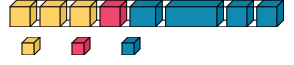

In [7]:
# Plot and save model structures

import visualkeras

visualkeras.layered_view(generator, legend=True, 
                              draw_volume=True)

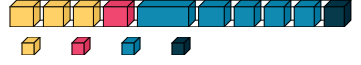

In [8]:


visualkeras.layered_view(discriminator,  legend=True, 
                              draw_volume=True)

In [21]:
import visualkeras

def save_visualkeras_plots(generator, discriminator):
    # Save generator model plot using visualkeras
    visualkeras.layered_view(generator, to_file='generator_visualkeras.png', legend=True)
    print("Generator model saved as 'generator_visualkeras.png'")

    # Save discriminator model plot using visualkeras
    visualkeras.layered_view(discriminator, to_file='discriminator_visualkeras.png', legend=True)
    print("Discriminator model saved as 'discriminator_visualkeras.png'")

# Example usage:
save_visualkeras_plots(generator, discriminator)



Generator model saved as 'generator_visualkeras.png'
Discriminator model saved as 'discriminator_visualkeras.png'


In [10]:


# Function to extract model summary into a DataFrame with error handling
def get_model_summary(model):
    summary_list = []
    for layer in model.layers:
        try:
            output_shape = layer.output_shape  # Try to access output_shape
        except AttributeError:
            output_shape = "N/A"  # Fallback value in case attribute is missing
            
        summary_list.append({
            'Layer Name': layer.name,
            'Layer Type': layer.__class__.__name__,
            'Output Shape': output_shape,
            'Param #': layer.count_params()
        })
    return pd.DataFrame(summary_list)

# Get summaries for generator and discriminator
gen_summary = get_model_summary(generator)
disc_summary = get_model_summary(discriminator)


In [11]:
# Convert output shapes to a numeric value for visualization
def convert_shape_to_numeric(shape):
    if shape != "N/A" and isinstance(shape, tuple):
        return int(shape[1]) if len(shape) > 1 else 1  # Use second dimension if it exists
    return 0

gen_summary['Output Size'] = gen_summary['Output Shape'].apply(convert_shape_to_numeric)
disc_summary['Output Size'] = disc_summary['Output Shape'].apply(convert_shape_to_numeric)


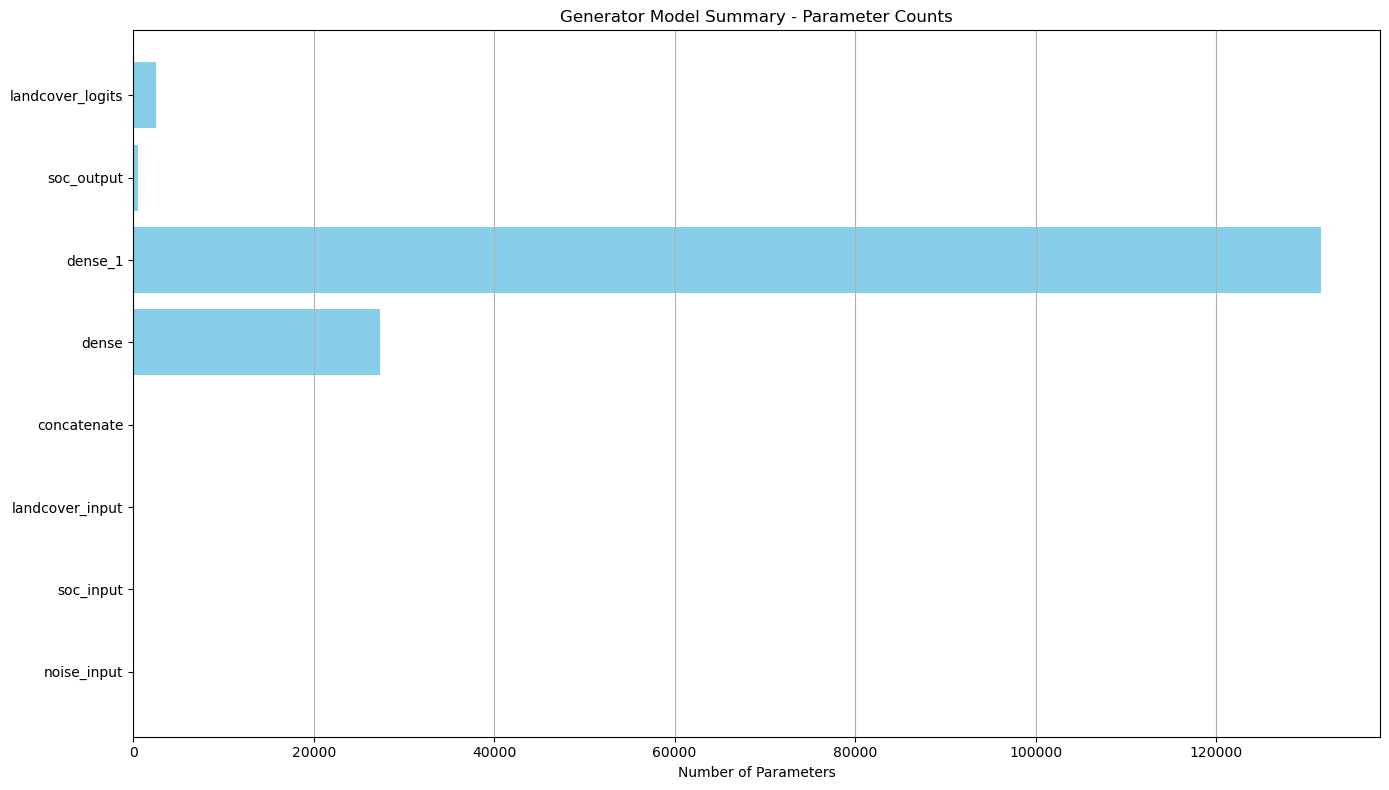

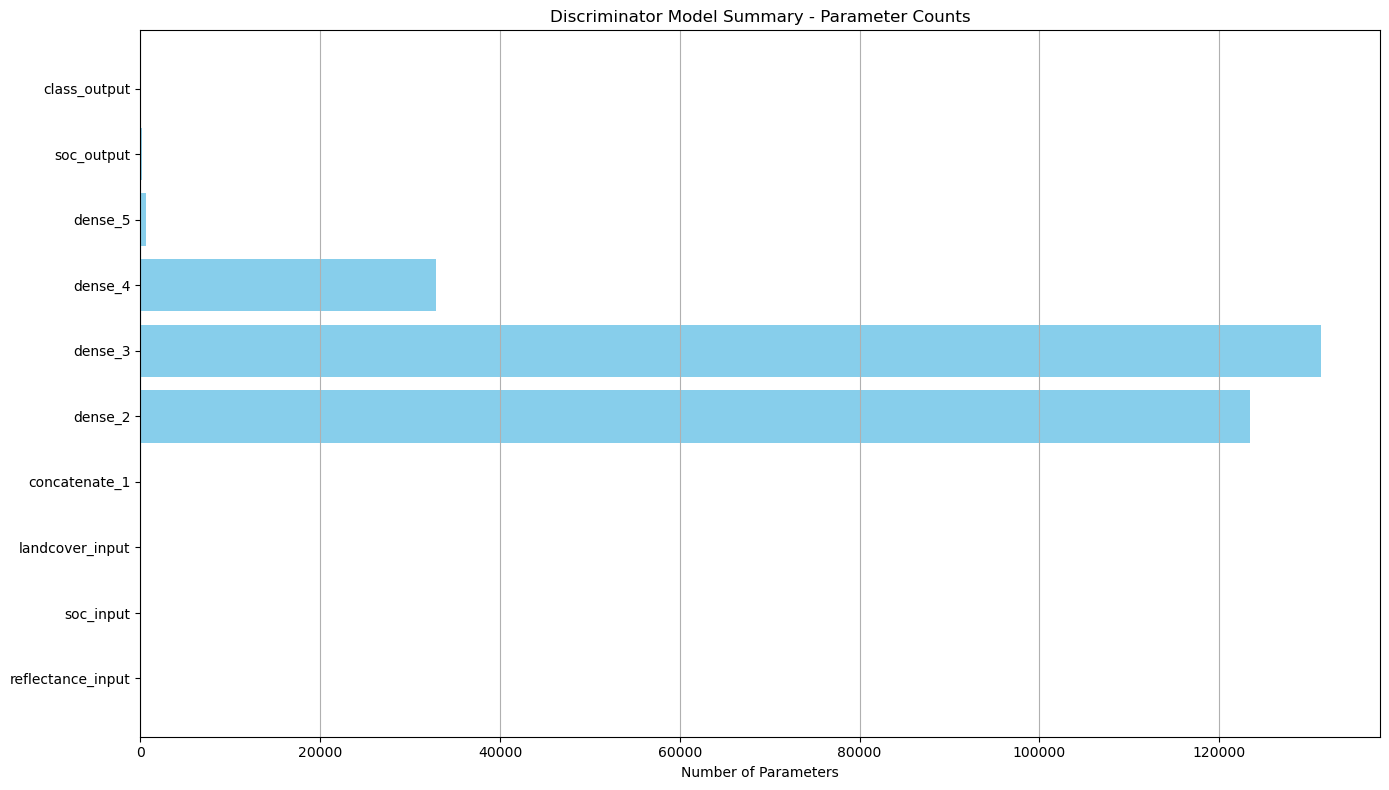

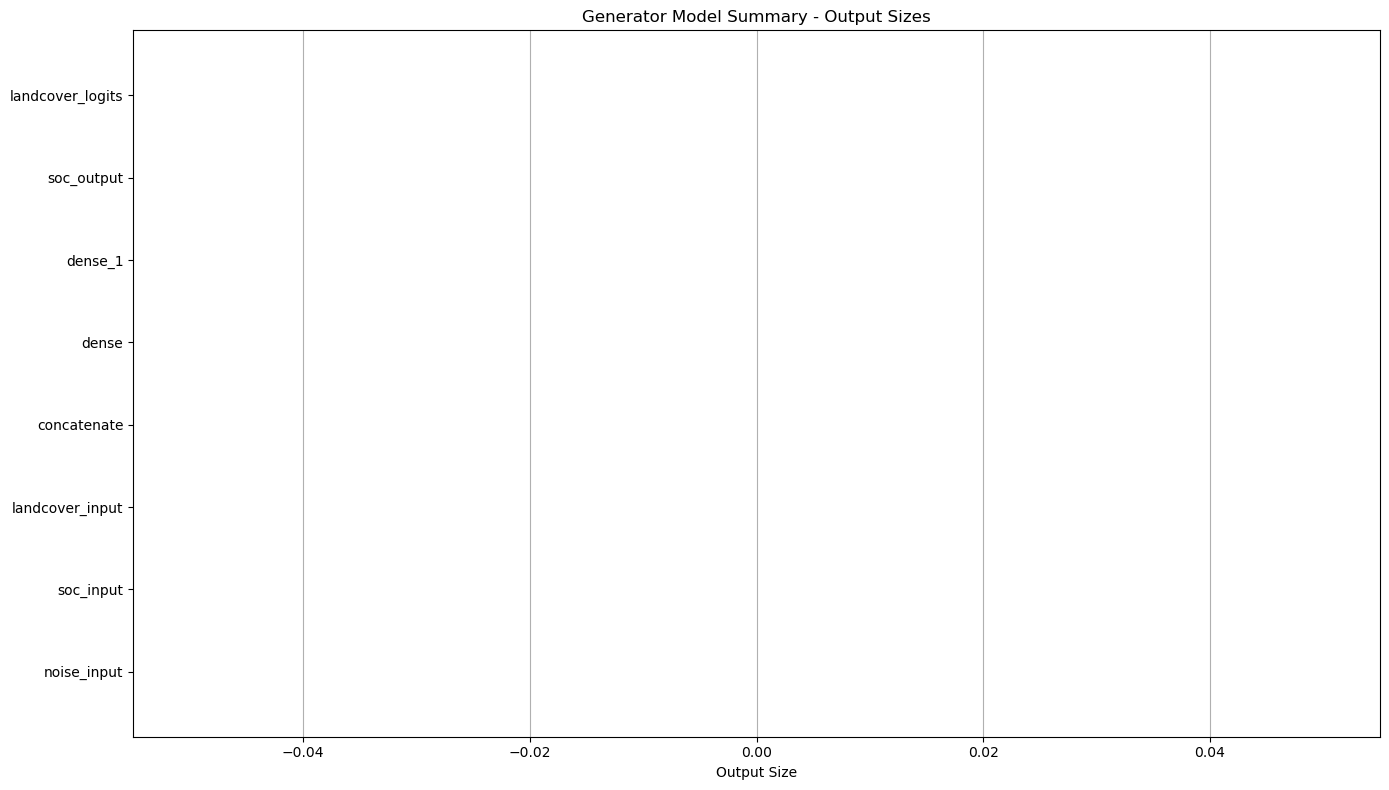

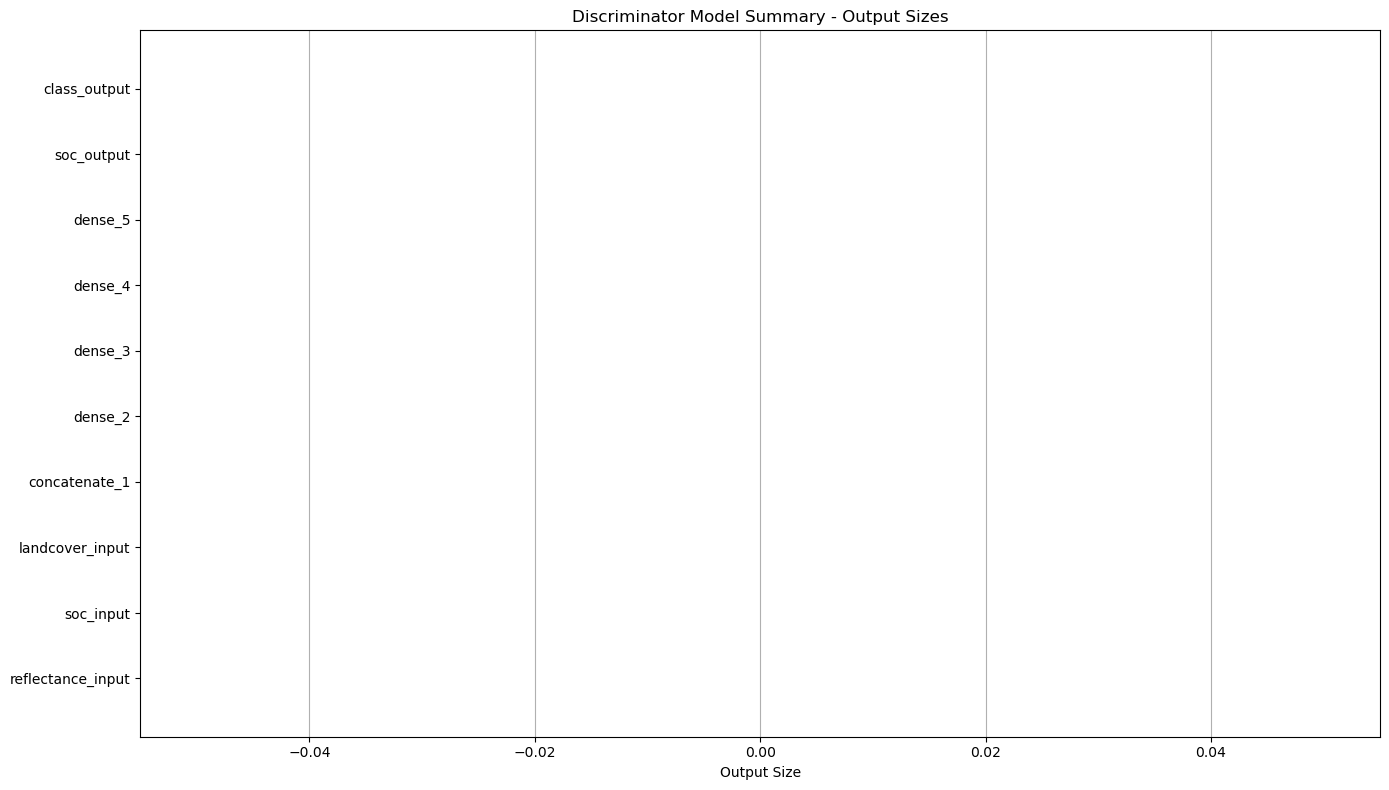

In [12]:
# Function to plot bar graphs for model summary
def plot_model_summary(summary_df, title):
    plt.figure(figsize=(14, 8))
    plt.barh(summary_df['Layer Name'], summary_df['Param #'], color='skyblue')
    plt.xlabel('Number of Parameters')
    plt.title(title)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Plotting the parameter count summaries
plot_model_summary(gen_summary, 'Generator Model Summary - Parameter Counts')
plot_model_summary(disc_summary, 'Discriminator Model Summary - Parameter Counts')

# Plotting the output sizes
def plot_output_size(summary_df, title):
    plt.figure(figsize=(14, 8))
    plt.barh(summary_df['Layer Name'], summary_df['Output Size'], color='salmon')
    plt.xlabel('Output Size')
    plt.title(title)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

plot_output_size(gen_summary, 'Generator Model Summary - Output Sizes')
plot_output_size(disc_summary, 'Discriminator Model Summary - Output Sizes')


Saved plot at: model_plots/generator_param_counts.png


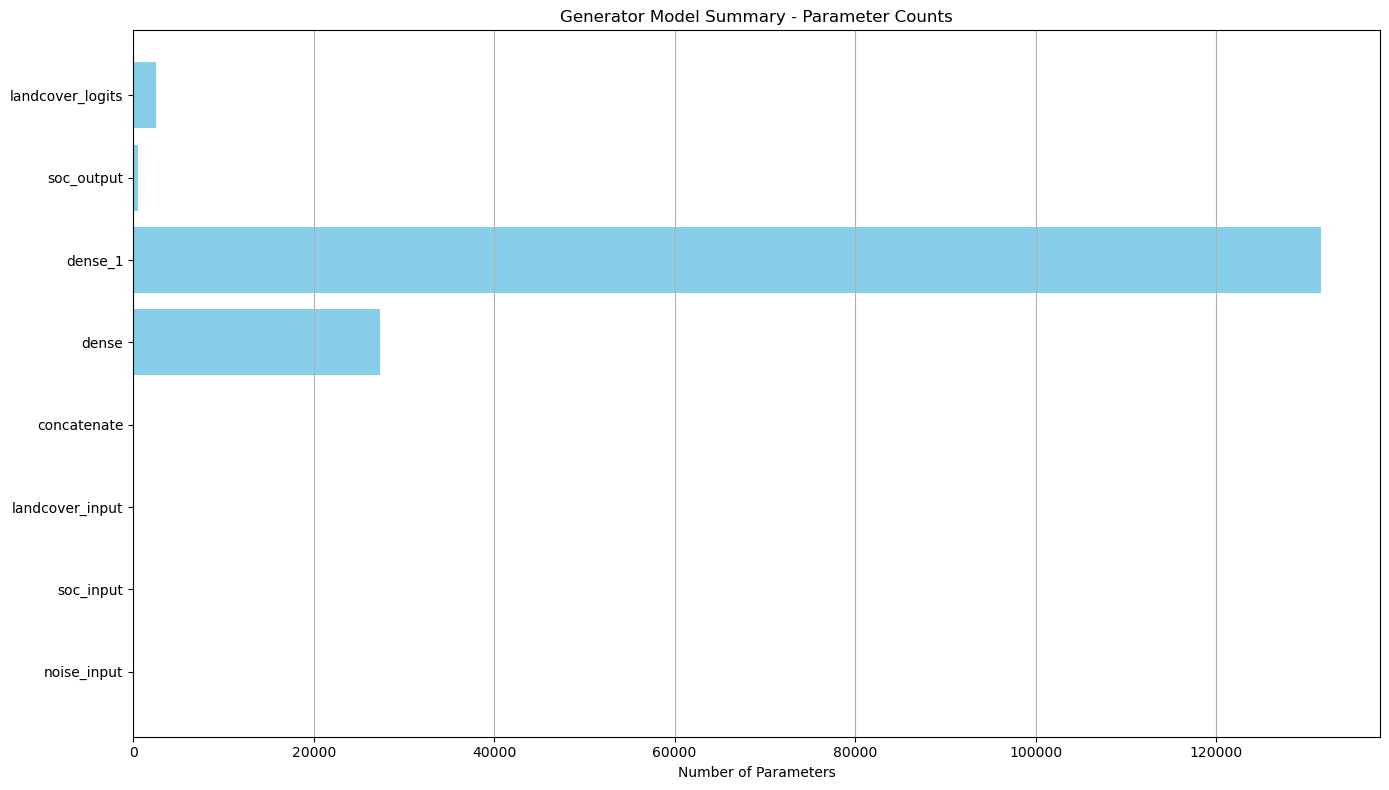

Saved plot at: model_plots/discriminator_param_counts.png


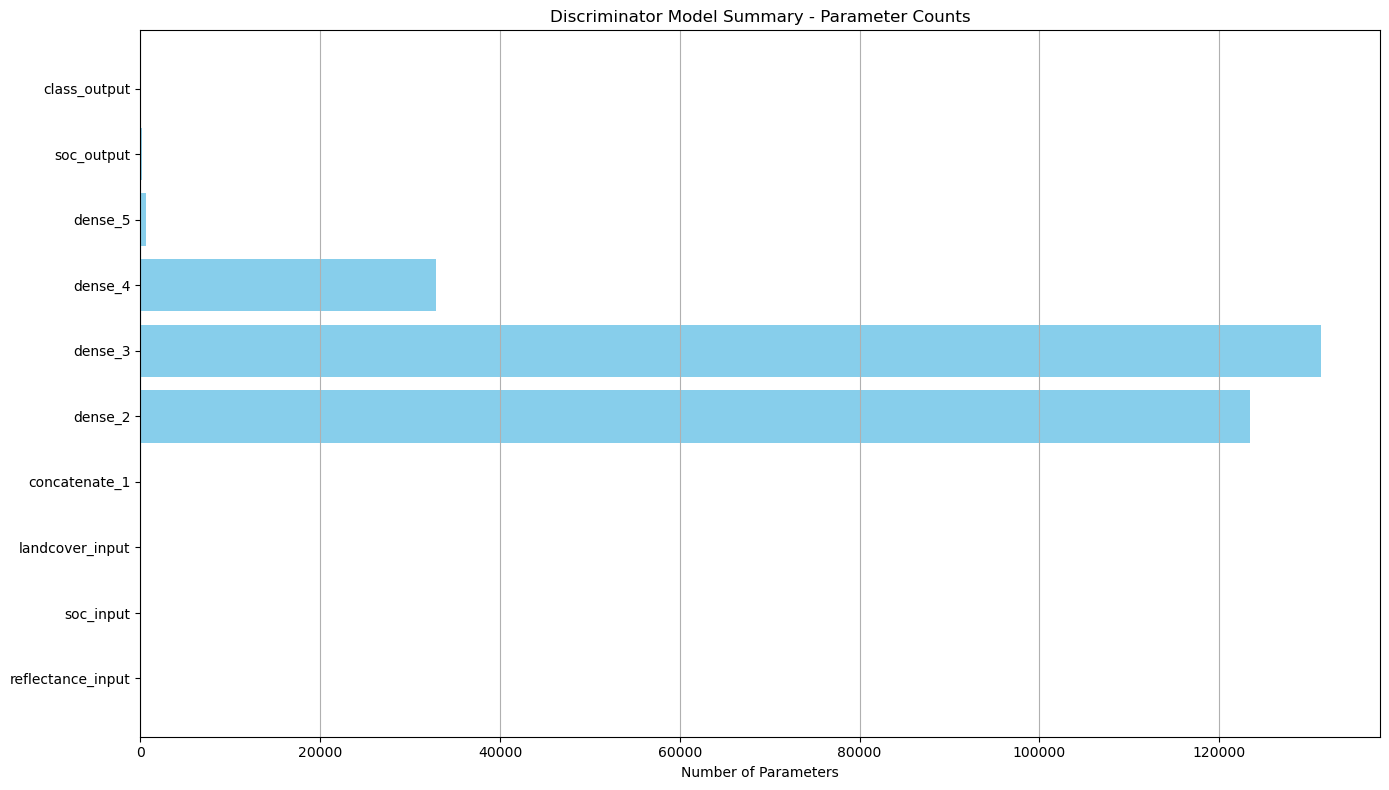

Saved plot at: model_plots/rccgan_param_counts.png


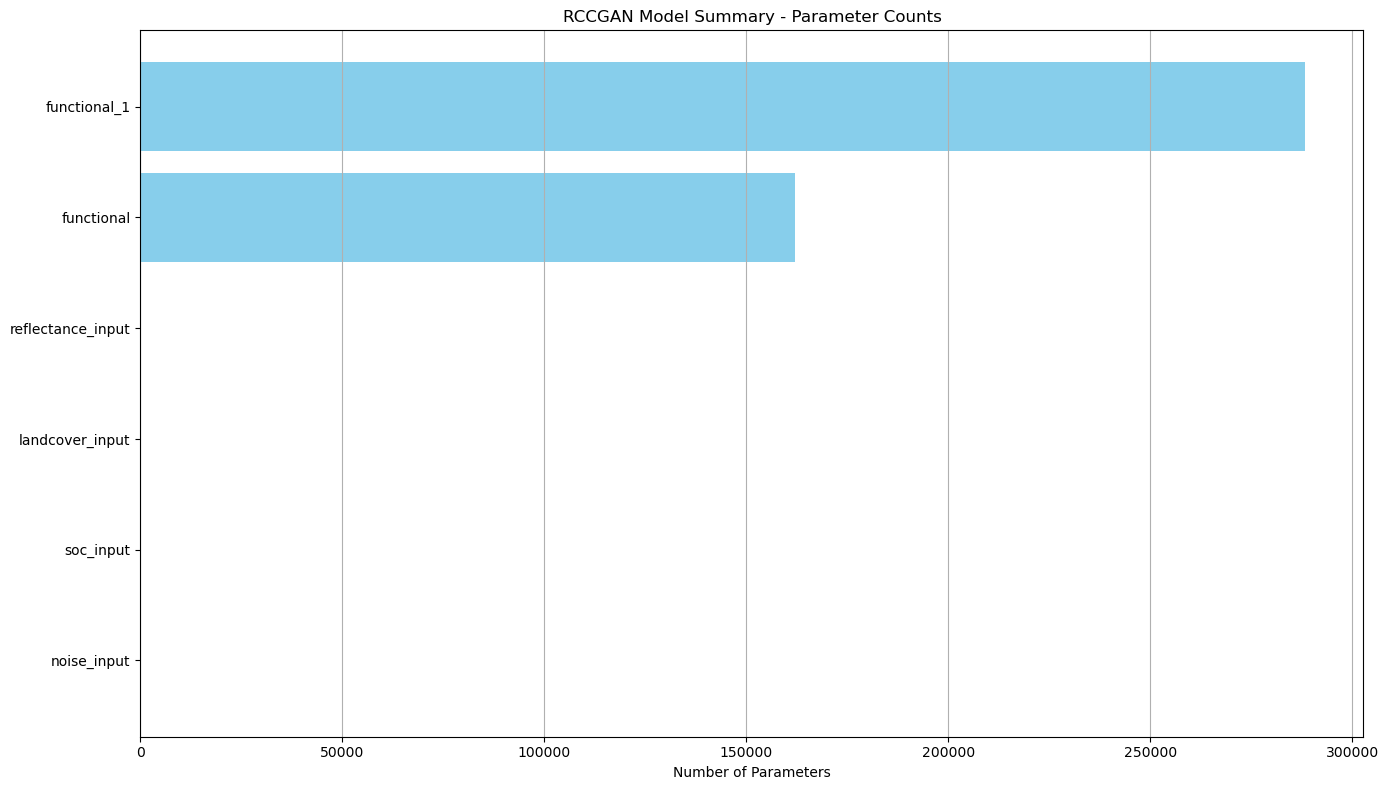

Saved plot at: model_plots/generator_output_sizes.png


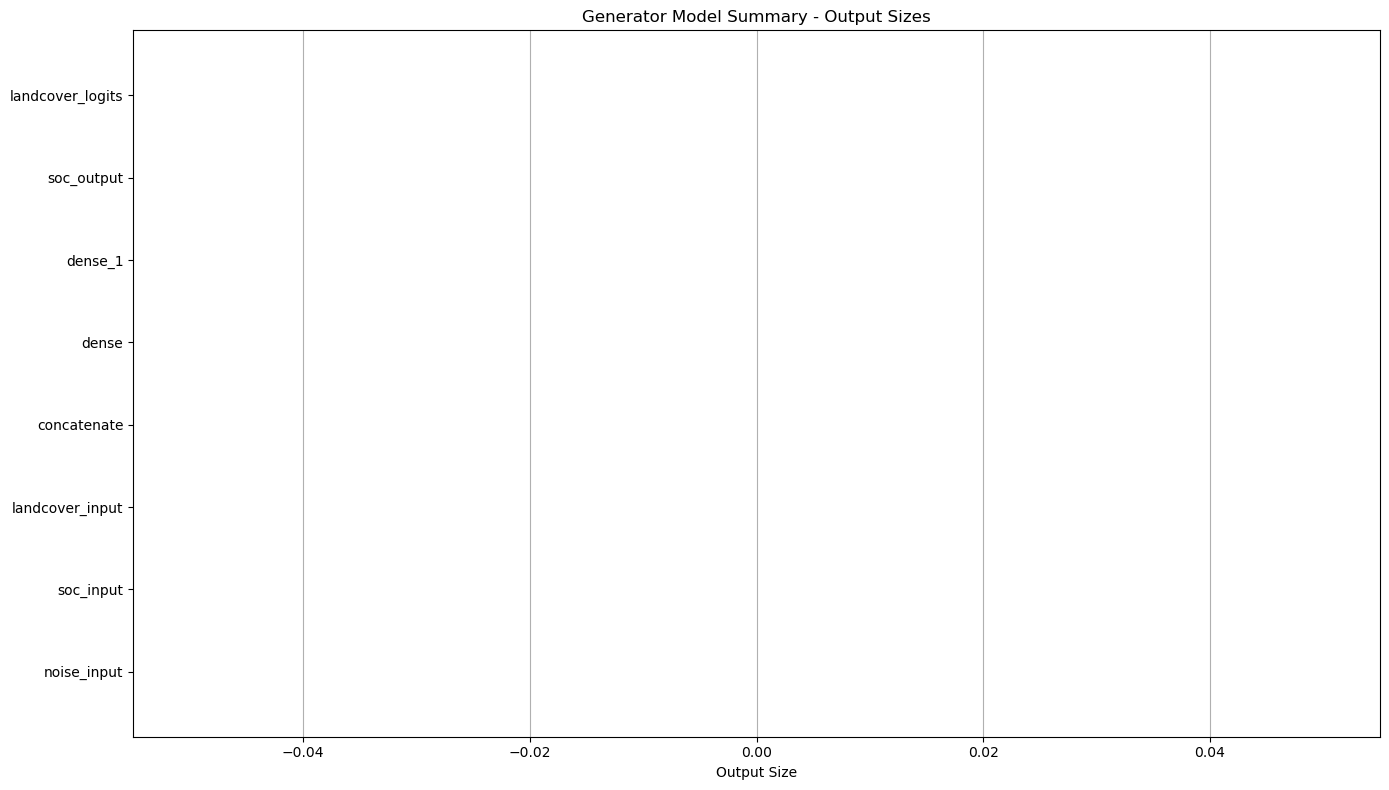

Saved plot at: model_plots/discriminator_output_sizes.png


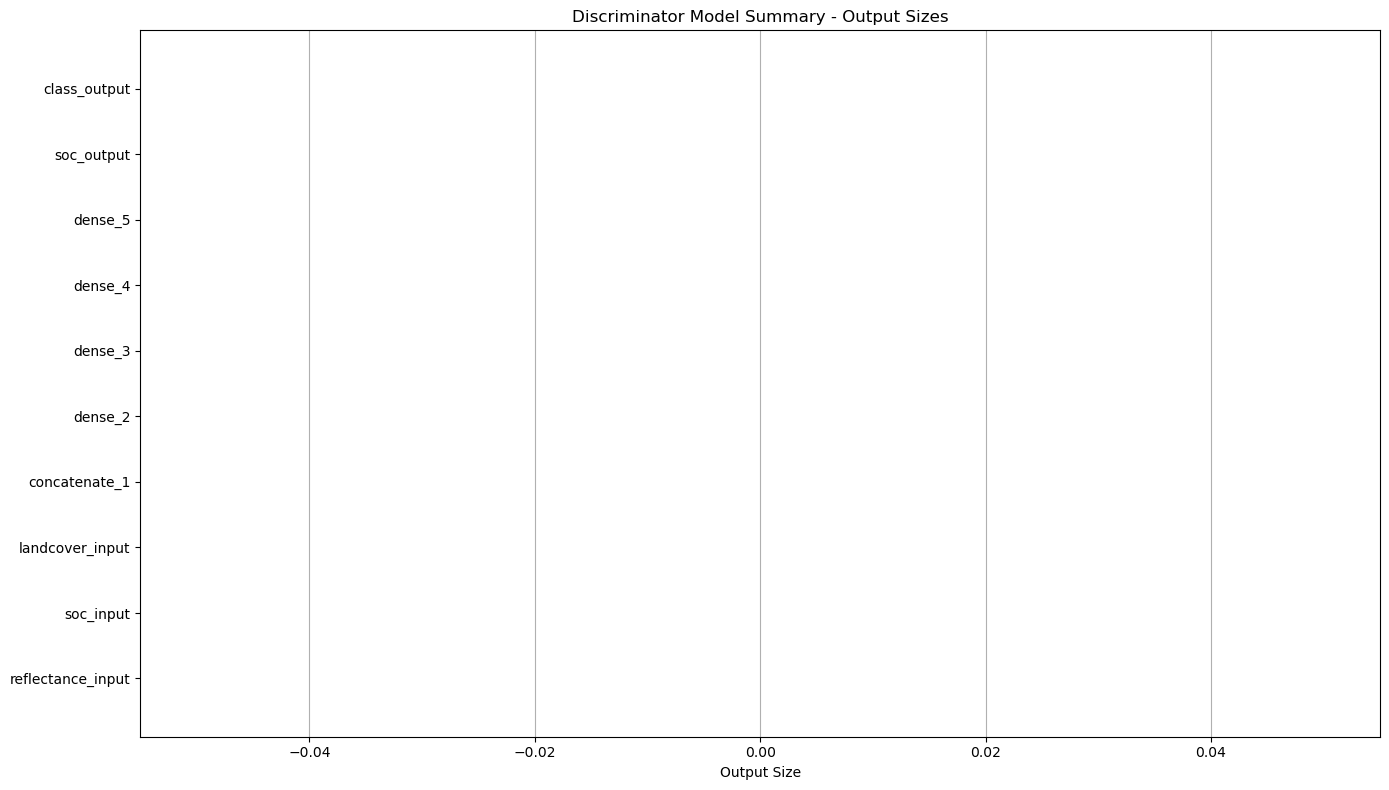

KeyError: 'Output Size'

<Figure size 1400x800 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import os
rccgan_summary = get_model_summary(rccgan_model)
# Function to plot bar graphs for model summary
def plot_model_summary(summary_df, title, save_path=None):
    plt.figure(figsize=(14, 8))
    plt.barh(summary_df['Layer Name'], summary_df['Param #'], color='skyblue')
    plt.xlabel('Number of Parameters')
    plt.title(title)
    plt.grid(axis='x')
    plt.tight_layout()
    
    # Save the plot if a path is specified
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Saved plot at: {save_path}")
    
    plt.show()
    plt.close()

# Plotting the parameter count summaries for Generator, Discriminator, and RCCGAN models
plot_model_summary(gen_summary, 'Generator Model Summary - Parameter Counts', save_path='model_plots/generator_param_counts.png')
plot_model_summary(disc_summary, 'Discriminator Model Summary - Parameter Counts', save_path='model_plots/discriminator_param_counts.png')
plot_model_summary(rccgan_summary, 'RCCGAN Model Summary - Parameter Counts', save_path='model_plots/rccgan_param_counts.png')

# Plotting the output sizes
def plot_output_size(summary_df, title, save_path=None):
    plt.figure(figsize=(14, 8))
    plt.barh(summary_df['Layer Name'], summary_df['Output Size'], color='salmon')
    plt.xlabel('Output Size')
    plt.title(title)
    plt.grid(axis='x')
    plt.tight_layout()
    
    # Save the plot if a path is specified
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Saved plot at: {save_path}")
    
    plt.show()
    plt.close()

# Plot output sizes for Generator, Discriminator, and RCCGAN models
plot_output_size(gen_summary, 'Generator Model Summary - Output Sizes', save_path='model_plots/generator_output_sizes.png')
plot_output_size(disc_summary, 'Discriminator Model Summary - Output Sizes', save_path='model_plots/discriminator_output_sizes.png')
plot_output_size(rccgan_summary, 'RCCGAN Model Summary - Output Sizes', save_path='model_plots/rccgan_output_sizes.png')
